<a href="https://colab.research.google.com/github/ChirathiSomadasa/Deep_Learning_Assignment/blob/Dilhara-U.G.T---2/Deep_Learning_Assignment_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Disease Classification**


## **Somadasa N.M.C.U. - IT22354242**

### Transfer Learning Specialist — MobileNetV2

In [ ]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzip
!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# STEP 2: Fix folder structure if nested
import os
import shutil

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

# STEP 3: Create smaller dataset for fast demo (200 images/class)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# STEP 4: DATA PREPROCESSING — USE MOBILENETV2-SPECIFIC PREPROCESSING
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # CRITICAL

# Use preprocess_input instead of rescale=1./255
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2-specific preprocessing
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print(f"Training samples: {train_data.samples}, Validation samples: {val_data.samples}")
print("Classes:", train_data.class_indices)


Found 2362 images belonging to 16 classes.
Found 589 images belonging to 16 classes.
Training samples: 2362, Validation samples: 589
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14, 'plantvillage': 15}


In [ ]:
# STEP 5: BUILD MOBILENETV2 MODEL — STAGE 1
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all base layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile for Stage 1 training
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Stage 1
early_stop_stage1 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# STEP 6: TRAIN STAGE 1 — TRAIN HEAD ONLY
print("\n=== STAGE 1: Training Head (Base Frozen) ===")
history_stage1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stop_stage1]
)

# STEP 7: FINE-TUNING STAGE 2 — UNFREEZE TOP LAYERS + LOW LR
print("\n=== STAGE 2: Fine-Tuning Top Layers ===")

# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with LOW learning rate (critical for fine-tuning)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add ReduceLROnPlateau for better convergence
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
early_stop_stage2 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train for additional epochs
history_stage2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop_stage2, lr_scheduler]
)

# STEP 8: EVALUATE MODEL — AFTER FULL TRAINING (STAGE 1 + STAGE 2)
print("\n=== FINAL MODEL EVALUATION ===")
final_loss, final_acc = model.evaluate(val_data)
print(f"FINAL Validation Accuracy after Fine-Tuning: {final_acc:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== STAGE 1: Training Head (Base Frozen) ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 694ms/step - accuracy: 0.2943 - loss: 2.3273 - val_accuracy: 0.6689 - val_loss: 1.0428
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 693ms/step - accuracy: 0.6787 - loss: 1.0093 - val_accuracy: 0.7538 - val_loss: 0.7810
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 656ms/step - accuracy: 0.7515 - loss: 0.7895 - val_accuracy: 0.7810 - val_loss: 0.6831
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 673ms/step - accuracy: 0.7897 - loss: 0.6593 - val_accuracy: 0.8353 - val_loss: 0.5526
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 52s 691ms/step - accuracy: 0.8207 - loss: 0.5355 - val_accuracy: 0.8200 - val_loss: 0.5660

=== STAGE 2: Fine-Tuning Top Layers ===
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 917ms/step - accuracy: 0.6438 - loss: 1.1545 - val_accuracy: 0.6112 - val_loss: 1.3844 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 875ms/step - accuracy: 0.8584 - loss: 0.4743 - val_accuracy: 0.6027 - val_loss: 1.4988 - learning_rate: 1.0000e-04
Epoch

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


# Path to your test image

img_path = "/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"

# Load & preprocess image

img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # rescale

# Predict

pred = model.predict(img_array)
class_index = np.argmax(pred, axis=1)[0]

# Map prediction to class label

# Make sure to invert the class_indices dict
class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_label = class_labels[class_index]

print(f"Predicted Disease: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Disease: Tomato_Septoria_leaf_spot


In [ ]:
# Save model

model.save("/content/mobilenetv2_plant_disease_model.keras")
print("\nModel saved to: /content/mobilenetv2_plant_disease_model.h5")



Model saved to: /content/mobilenetv2_plant_disease_model.h5


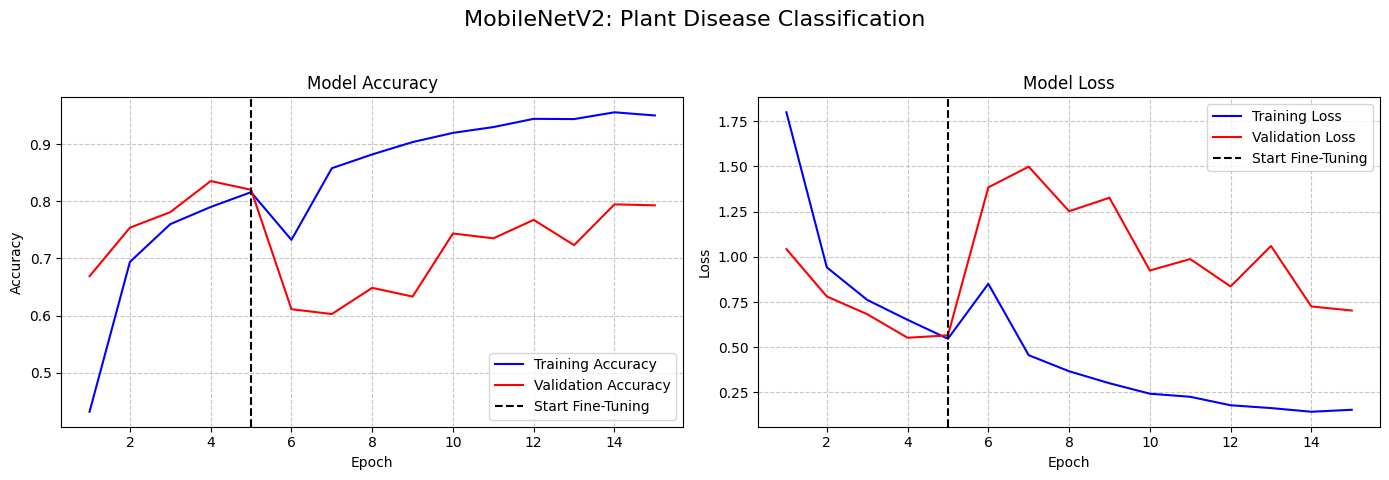

In [ ]:
# VISUALIZE MOBILENETV2 TRAINING PERFORMANCE (Stage 1 + Stage 2)


import matplotlib.pyplot as plt

# Combine histories from both stages
def plot_combined_history(history1, history2, title="MobileNetV2 Training Performance"):
    # Concatenate metrics
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    #  Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    # Mark stage transition
    plt.axvline(x=len(history1.history['accuracy']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    #  Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with your histories
plot_combined_history(history_stage1, history_stage2, title="MobileNetV2: Plant Disease Classification")

In [ ]:
# Generate classification report
from sklearn.metrics import classification_report
import numpy as np

# Reset and get predictions
val_data.reset()
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes present in validation set
unique_labels = np.unique(y_true)

# Map to class names (only for classes that appear)
class_indices = val_data.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Create target_names in the correct order (0 to max label)
max_label = max(unique_labels)
target_names_filtered = [idx_to_class[i] for i in range(max_label + 1) if i in unique_labels]

# Generate report
report = classification_report(
    y_true,
    y_pred_classes,
    labels=unique_labels,
    target_names=target_names_filtered,
    zero_division=0
)

print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.08      0.05      0.06        40
                     Pepper__bell___healthy       0.07      0.07      0.07        40
                      Potato___Early_blight       0.07      0.07      0.07        40
                       Potato___Late_blight       0.00      0.00      0.00        40
                           Potato___healthy       0.10      0.10      0.10        30
                      Tomato_Bacterial_spot       0.09      0.07      0.08        40
                        Tomato_Early_blight       0.14      0.07      0.10        40
                         Tomato_Late_blight       0.09      0.07      0.08        40
                           Tomato_Leaf_Mold       0.06      0.05      0.05        40
                  Tomato_Septoria_leaf_spot       0.05      0.07      0.06        40
Tomato_Spider_mites_Tw

In [ ]:

# Get a sample batch from validation data
val_data.reset()
sample_batch, _ = next(val_data)
print(f"Sample batch shape: {sample_batch.shape}")
# Parameters
print(f"Parameters: {model.count_params():,}")

# Inference time (as shown earlier)
import time
start = time.time()
_ = model.predict(sample_batch, verbose=0)
inference_time = (time.time() - start) / len(sample_batch) * 1000  # ms per image

Sample batch shape: (32, 128, 128, 3)
Parameters: 2,424,016


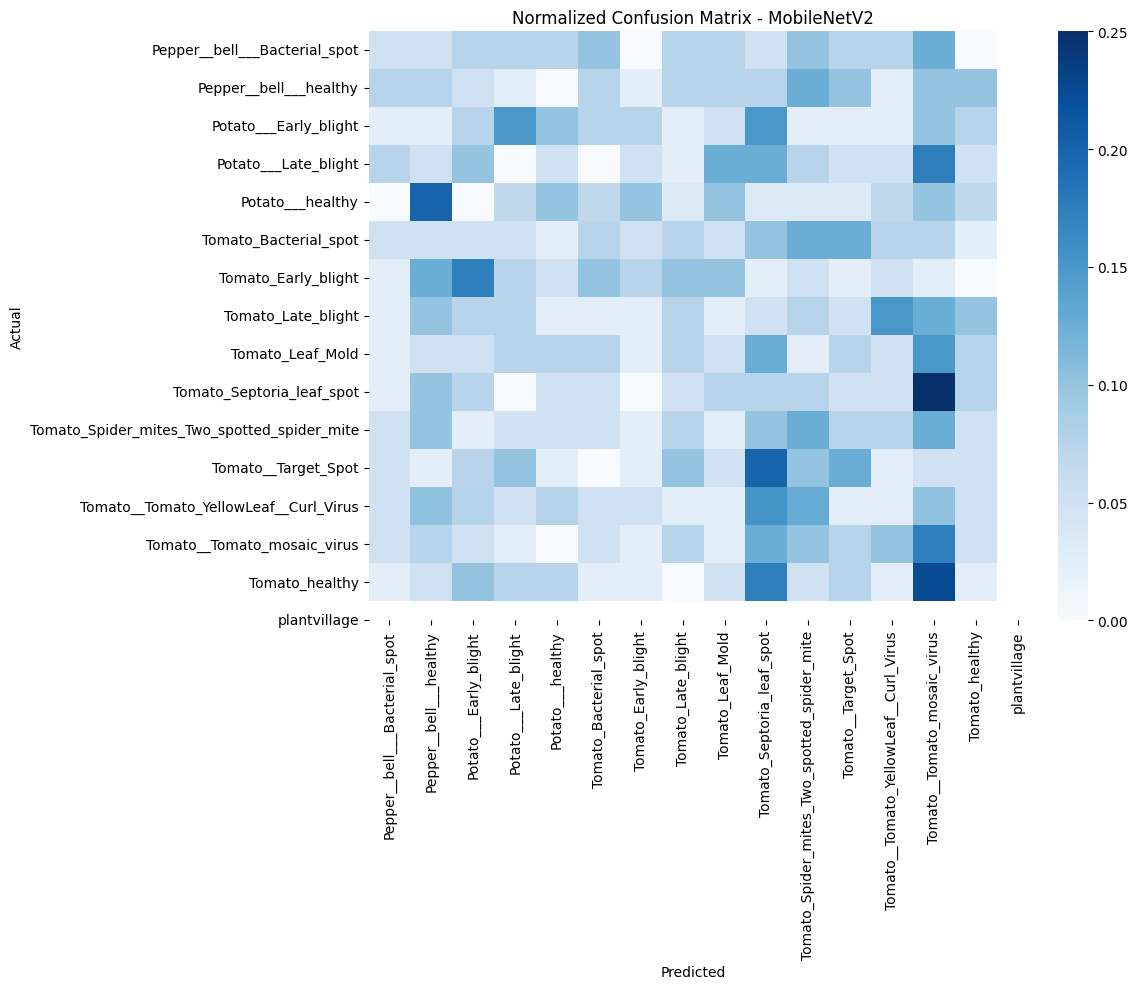

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Normalized Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##**Balasooriya B.M.P.U.  -  IT22927248**

### Transfer Leaning Specialist - Custom CNN

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# Fix folder structure if nested

import os
import shutil

In [ ]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

In [ ]:
# Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # reduce per class for fast execution

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Use the fast demo directory for training
data_dir = fast_dir

# Remove any empty directories
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        if len(os.listdir(class_path)) == 0:  # If folder is empty
            os.rmdir(class_path)
            print(f"Removed empty directory: {class_name}")


Removed empty directory: plantvillage


In [ ]:
# Create datasets using the modern approach
import tensorflow as tf

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2951 files belonging to 15 classes.
Using 2361 files for training.
Found 2951 files belonging to 15 classes.
Using 590 files for validation.


In [ ]:
# Apply data augmentation to training dataset

import tensorflow as tf

def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)
    return image, label

# Apply augmentation only to training data
train_ds = train_ds.map(augment_images)
# Normalize both datasets
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))

# Optimize performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training samples: {len(train_ds) * batch_size}")
print(f"Validation samples: {len(val_ds) * batch_size}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")


Training samples: 2368
Validation samples: 608
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# Design the custom CNN architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2184 - loss: 3.0727 - val_accuracy: 0.0610 - val_loss: 22.9388 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4587 - loss: 1.7497 - val_accuracy: 0.0610 - val_loss: 25.3359 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5383 - loss: 1.4737 - val_accuracy: 0.0610 - val_loss: 24.6076 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6029 - loss: 1.2437 - val_accuracy: 0.0610 - val_loss: 16.7589 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6440 - loss: 1.0839 - val_accuracy: 0.0610 - val_loss: 14.6252 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6894 - loss: 0.9433 - val_accuracy: 0.0966 - val_loss: 9.7032 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7340 - loss: 0.7977 - va

In [ ]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 438ms/step - accuracy: 0.7926 - loss: 0.7223
Validation Accuracy: 80.34%


In [ ]:
# 9. Predictions + classification report

import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.88      0.73      0.80        41
                     Pepper__bell___healthy       0.84      0.95      0.89        39
                      Potato___Early_blight       0.95      0.84      0.89        43
                       Potato___Late_blight       0.59      0.84      0.70        38
                           Potato___healthy       0.85      0.97      0.91        35
                      Tomato_Bacterial_spot       0.61      0.91      0.73        33
                        Tomato_Early_blight       0.73      0.58      0.65        38
                         Tomato_Late_blight       0.79      0.55      0.65        47
                           Tomato_Leaf_Mold       0.85      0.85      0.85        33
                  Tomato_Septoria_leaf_spot       0.84      0.58      0.69        36
Tomato_Spider_mites_Two_spotted_spider_mite       0.85      0.88

In [ ]:
# Model save:

model.save('custom_cnn_plant_disease.keras')
print("Model saved as 'custom_cnn_plant_disease.keras'")

Model saved as 'custom_cnn_plant_disease.keras'


In [ ]:
# Function to predict on new images

def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    return class_names[predicted_class], confidence

In [ ]:
# Test the prediction function with a sample image_1

sample_image_path = "/content/PlantVillage/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Disease: Tomato_Bacterial_spot with confidence: 0.89


In [ ]:
# Test the prediction function with a sample image_2

sample_image_path = "/content/PlantVillage/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Disease: Tomato__Tomato_mosaic_virus with confidence: 1.00


## **Chandrasoma M.H.R - IT22347412**

### Smart Plant Disease Classifier - EfficientNetB0

In [ ]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
#Fix folder structure if nested

import os, shutil

In [ ]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)
print("Folder structure fixed!")

Folder structure fixed!


In [ ]:
# STEP 3: Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 500  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Removed empty directory: plantvillage
Fast demo dataset created at: /content/PlantVillage_FastDemo


In [ ]:
# STEP 4: Data Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes detected: {NUM_CLASSES}")

Found 5621 images belonging to 15 classes.
Found 1403 images belonging to 15 classes.
Number of classes detected: 15


In [ ]:
# STEP 5: Model Development (EfficientNetB0 + Custom Head)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze for Phase 1

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name="smart_plant_disease_classifier")

print("Model Summary:")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.0647 - loss: 2.7300 - val_accuracy: 0.0727 - val_loss: 2.6832
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.0794 - loss: 2.7087 - val_accuracy: 0.0748 - val_loss: 2.6827
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.0635 - loss: 2.7074 - val_accuracy: 0.0727 - val_loss: 2.6816
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.0761 - loss: 2.7111 - val_accuracy: 0.0713 - val_loss: 2.6814
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 623s 4s/step - accuracy: 0.0749 - loss: 2.6979 - val_accuracy: 0.0941 - val_loss: 2.6801


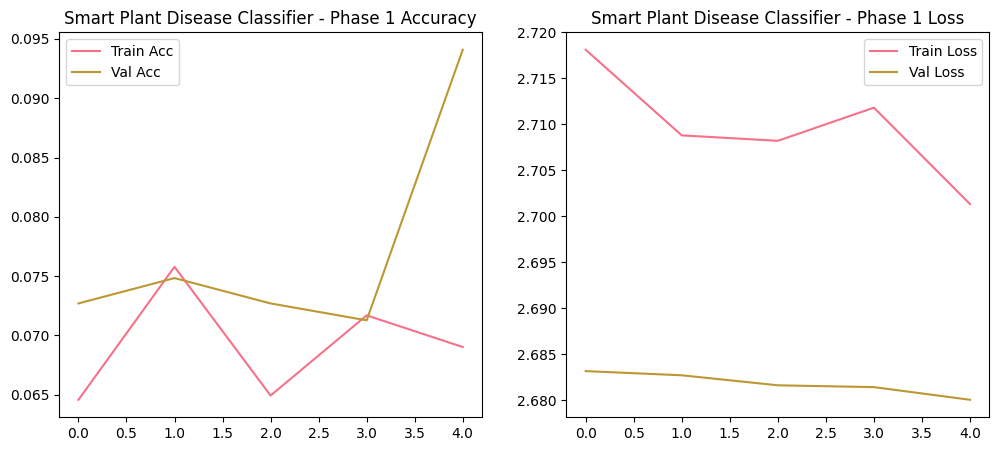

In [ ]:
# STEP 6: Training Phase 1 (Feature Extraction)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ckpt = ModelCheckpoint("best_phase1_model.keras", monitor='val_accuracy', save_best_only=True)

history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[es, ckpt]
)

# Plot Phase 1 Metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 1 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 1 Loss")
plt.legend()
plt.show()


In [ ]:
# STEP 7: Training Phase 2 (Fine-Tuning)
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Unfreeze last 80 layers of the base model
for layer in base_model.layers[-80:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
es2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt2 = ModelCheckpoint("best_phase2_model.keras", monitor='val_accuracy', save_best_only=True)

# Fine-tune the model
history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[es2, ckpt2]
)

# Plot Phase 2 Metrics
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 2 Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 2 Loss")
plt.legend()

plt.show()

In [ ]:
# STEP 8: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate final model
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Predictions
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Smart Plant Disease Classifier - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(valid_generator.class_indices.keys())))


In [ ]:
# STEP 9: Test Prediction Function
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_disease(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    from tensorflow.keras.applications.efficientnet import preprocess_input
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class = list(train_generator.class_indices.keys())[np.argmax(preds)]
    confidence = np.max(preds)
    return predicted_class, confidence

# Test with one image
sample_image_path = "/content/PlantVillage/Pepper__bell___healthy/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL 7886.JPG"
pred_class, conf = predict_disease(sample_image_path)
print(f"Predicted Disease: {pred_class} with confidence: {conf:.2f}")

In [ ]:
# STEP 10: Save Model
model.save("smart_plant_disease_classifier.keras")
print("Model saved as smart_plant_disease_classifier.keras")

## **Dilhara U.G.T - IT22309624**

### Plant Disease Classification using Deep Learning - Vision Transformer (ViT) Pioneer

#### Initionating the model

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/Colab Notebooks/DL Assignment/archive.zip" -d "/content/PlantVillage"

In [3]:
# Fix folder structure if nested

import os
import shutil


# Check if inner folder exists

# Define the expected path to the unzipped dataset
dataset_path = '/content/PlantVillage'

# Check if a common inner folder exists ('PlantVillage')
inner_folder_name = 'PlantVillage'
inner_folder_path = os.path.join(dataset_path, inner_folder_name)

if os.path.exists(inner_folder_path) and os.path.isdir(inner_folder_path):
    print(f"Inner folder '{inner_folder_name}' found at: {inner_folder_path} \n")
    # List contents of the inner folder
    print("Contents of the inner folder: \n")
    for item in os.listdir(inner_folder_path):
        print(item)
else:
    print(f"Inner folder '{inner_folder_name}' not found at: {inner_folder_path}")
    # If the common inner folder is not found, list the contents of the main dataset directory
    print(f"Contents of the main dataset directory ({dataset_path}):")
    for item in os.listdir(dataset_path):
        print(item)


Inner folder 'PlantVillage' found at: /content/PlantVillage/PlantVillage 

Contents of the inner folder: 

Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Pepper__bell___Bacterial_spot
Potato___Late_blight
Tomato__Target_Spot
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Potato___healthy
Pepper__bell___healthy
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus
Tomato_Early_blight
Potato___Early_blight
Tomato_Late_blight
Tomato_Leaf_Mold


In [4]:
# Create smaller dataset for fast demo (optional)

original_dir = "/content/PlantVillage/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Fast demo dataset created at: /content/PlantVillage_FastDemo


In [5]:
# Data Preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/PlantVillage/PlantVillage"
IMG_SIZE = 224  # Typical for ViT
BATCH_SIZE = 32
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Number of classes detected: {NUM_CLASSES}")
print("Classes:", class_names)

# Rescale the datasets
def rescale_images(image, label):
    image = image / 255.0
    return image, label

train_ds = train_ds.map(rescale_images)
val_ds = val_ds.map(rescale_images)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1), # Corresponds to rotation_range=20 (approx 0.1 rad)
    tf.keras.layers.RandomZoom(0.2, 0.2), # Corresponds to zoom_range=0.2
])

# Apply augmentation only to training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 2952 files belonging to 15 classes.
Using 2362 files for training.
Found 2952 files belonging to 15 classes.
Using 590 files for validation.
Number of classes detected: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


#### Model Development

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, callbacks, optimizers

IMG_SIZE = 224
NUM_CLASSES = 15


# Load a pre-trained ViT model from TensorFlow Hub ( ViT-B/16)
# URL: https://tfhub.dev/sayakpaul/vit_b16_fe/1 (feature extractor, no classification head)
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

vit_layer = hub.KerasLayer(
    vit_url,
    trainable=False  # freeze for Phase 1
)


# Model definition
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)  # normalize input
# x = layers.Lambda(lambda t: vit_layer(t))(x)       # ViT feature extractor
x = layers.Lambda(lambda t: vit_layer(t), output_shape=(768,))(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

vit_model = models.Model(inputs=inputs, outputs=outputs, name="smart_plant_disease_classifier")

print("Model Summary:")
vit_model.summary()


Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,471 (1.54 MB)

 Trainable params: 402,447 (1.54 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [10]:
# Compile
vit_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-2),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_learning_rate=1e-4
)


# Train model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate model

loss, acc = vit_model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 71s 850ms/step - accuracy: 0.3569 - loss: 2.0166 - val_accuracy: 0.0610 - val_loss: 37.8049 - learning_rate: 0.0100
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 725ms/step - accuracy: 0.3704 - loss: 1.9462 - val_accuracy: 0.0898 - val_loss: 25.6716 - learning_rate: 0.0100
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 749ms/step - accuracy: 0.3607 - loss: 1.9199 - val_accuracy: 0.1203 - val_loss: 29.9000 - learning_rate: 0.0100
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 664ms/step - accuracy: 0.3858 - loss: 1.8589 - val_accuracy: 0.1051 - val_loss: 28.7799 - learning_rate: 0.0100
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 743ms/step - accuracy: 0.3858 - loss: 1.9165 - val_accuracy: 0.0814 - val_loss: 28.8325 - learning_rate: 0.0100
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 754ms/step - accuracy: 0.3732 - loss: 1.8863 - val_accuracy: 0.0593 - val_loss: 27.4165 - learning_rate: 0.0100
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 749ms/step - accuracy: 0.3868 - lo

In [14]:
# 1. Unfreeze the ViT layer for fine-tuning
vit_layer.trainable = True

# 2. Re-compile with lower learning rate for fine-tuning
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Lower LR!
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3. (Optional but recommended) Re-enable callbacks
early_stop_finetune = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr_finetune = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    min_learning_rate=1e-5
)

# 4. Fine-tune (train) for a few more epochs
history_finetune = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # for fine-tuning
    callbacks=[early_stop_finetune, reduce_lr_finetune],
    verbose=1
)


# 5. Evaluate model
loss, acc = vit_model.evaluate(val_ds)
print(f"Validation Accuracy after fine-tune: {acc:.4f}")
print(f"Validation Accuracy after fine-tune: {acc * 100:.2f}%")

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 73s 861ms/step - accuracy: 0.5110 - loss: 1.5327 - val_accuracy: 0.1729 - val_loss: 6.6428 - learning_rate: 0.0010
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 692ms/step - accuracy: 0.5006 - loss: 1.5052 - val_accuracy: 0.2746 - val_loss: 4.5041 - learning_rate: 0.0010
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 696ms/step - accuracy: 0.5065 - loss: 1.5741 - val_accuracy: 0.2034 - val_loss: 4.0785 - learning_rate: 0.0010
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 732ms/step - accuracy: 0.4933 - loss: 1.5309 - val_accuracy: 0.2627 - val_loss: 3.8339 - learning_rate: 0.0010
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 84s 768ms/step - accuracy: 0.4810 - loss: 1.5936 - val_accuracy: 0.1203 - val_loss: 6.2563 - learning_rate: 0.0010
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.2617 - loss: 3.9408
Validation Accuracy after fine-tune: 0.2627
Validation Accuracy after fine-tune: 26.27%


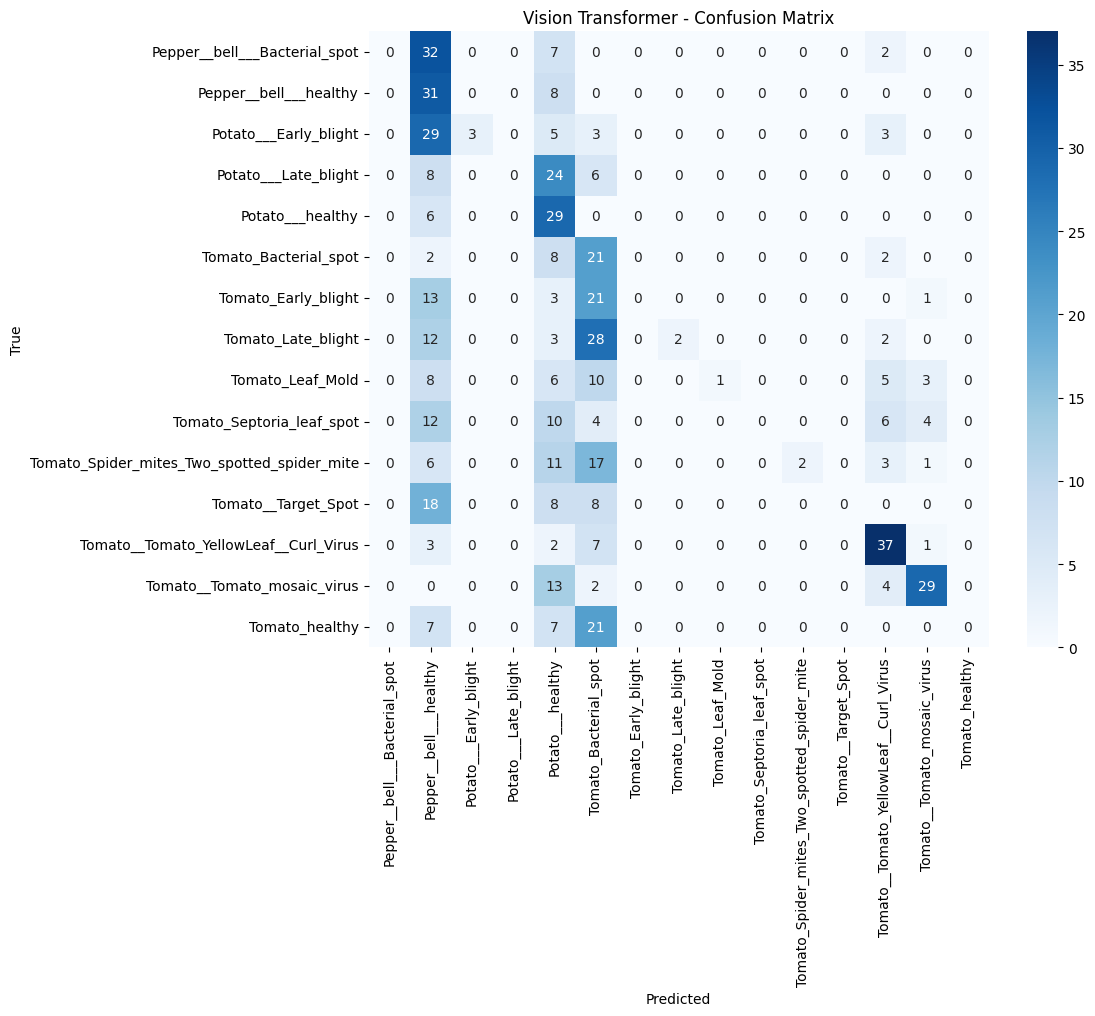

Classification Report for Vision Transformer Model:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00        41
                     Pepper__bell___healthy       0.17      0.79      0.27        39
                      Potato___Early_blight       1.00      0.07      0.13        43
                       Potato___Late_blight       0.00      0.00      0.00        38
                           Potato___healthy       0.20      0.83      0.32        35
                      Tomato_Bacterial_spot       0.14      0.64      0.23        33
                        Tomato_Early_blight       0.00      0.00      0.00        38
                         Tomato_Late_blight       1.00      0.04      0.08        47
                           Tomato_Leaf_Mold       1.00      0.03      0.06        33
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00        36
Tomato_Spide

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = vit_model.predict(images, verbose=0)
    # If labels are integer class indices:
    y_true.extend(labels.numpy())  # No argmax needed
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vision Transformer - Confusion Matrix')
plt.show()

# 3. Classification Report
print("Classification Report for Vision Transformer Model:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# 4. Overall Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"Overall Validation Accuracy: {acc:.4f}")
print(f"Overall Validation Accuracy: {acc * 100:.2f}%")

In [16]:
# Save the entire model (architecture + weights + training config)
vit_model.save("smart_plant_disease_classifier_vit_finetuned_model.keras")
print("Model saved as smart_plant_disease_classifier_vit_finetuned_model.keras")

Model saved as smart_plant_disease_classifier_vit_finetuned_model.keras


# **PLANT DISEASE DETECTION - MODEL COMPARISON**

Mounted at /content/drive
Checking model files in Google Drive...
 MobileNetV2: Found
 Custom CNN: Found
 EfficientNetB0: Found
 Vision Transformer: Found
Recreating fast demo dataset...
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.

Classes (15): ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Validation samples: 590

Loading models from Google Drive...
 MobileNetV2 loaded
 Custom CNN loaded
 EfficientNetB0 loaded
  Error loading ViT: Exception encountered when calling Lambda.call().

We could not automatically 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating Custom CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating EfficientNetB0...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



FINAL MODEL COMPARISON RESULTS
         Model  Accuracy  Model Size (MB)  Parameters (M)  Inference Time (ms)
   MobileNetV2    0.8220          22.7415          2.4240              35.1786
    Custom CNN    0.6949          60.1371          5.2477              13.9354
EfficientNetB0    0.9186          41.1706          4.0688              90.2813

 Results saved to: /content/drive/MyDrive/DL/model_comparison_results.csv


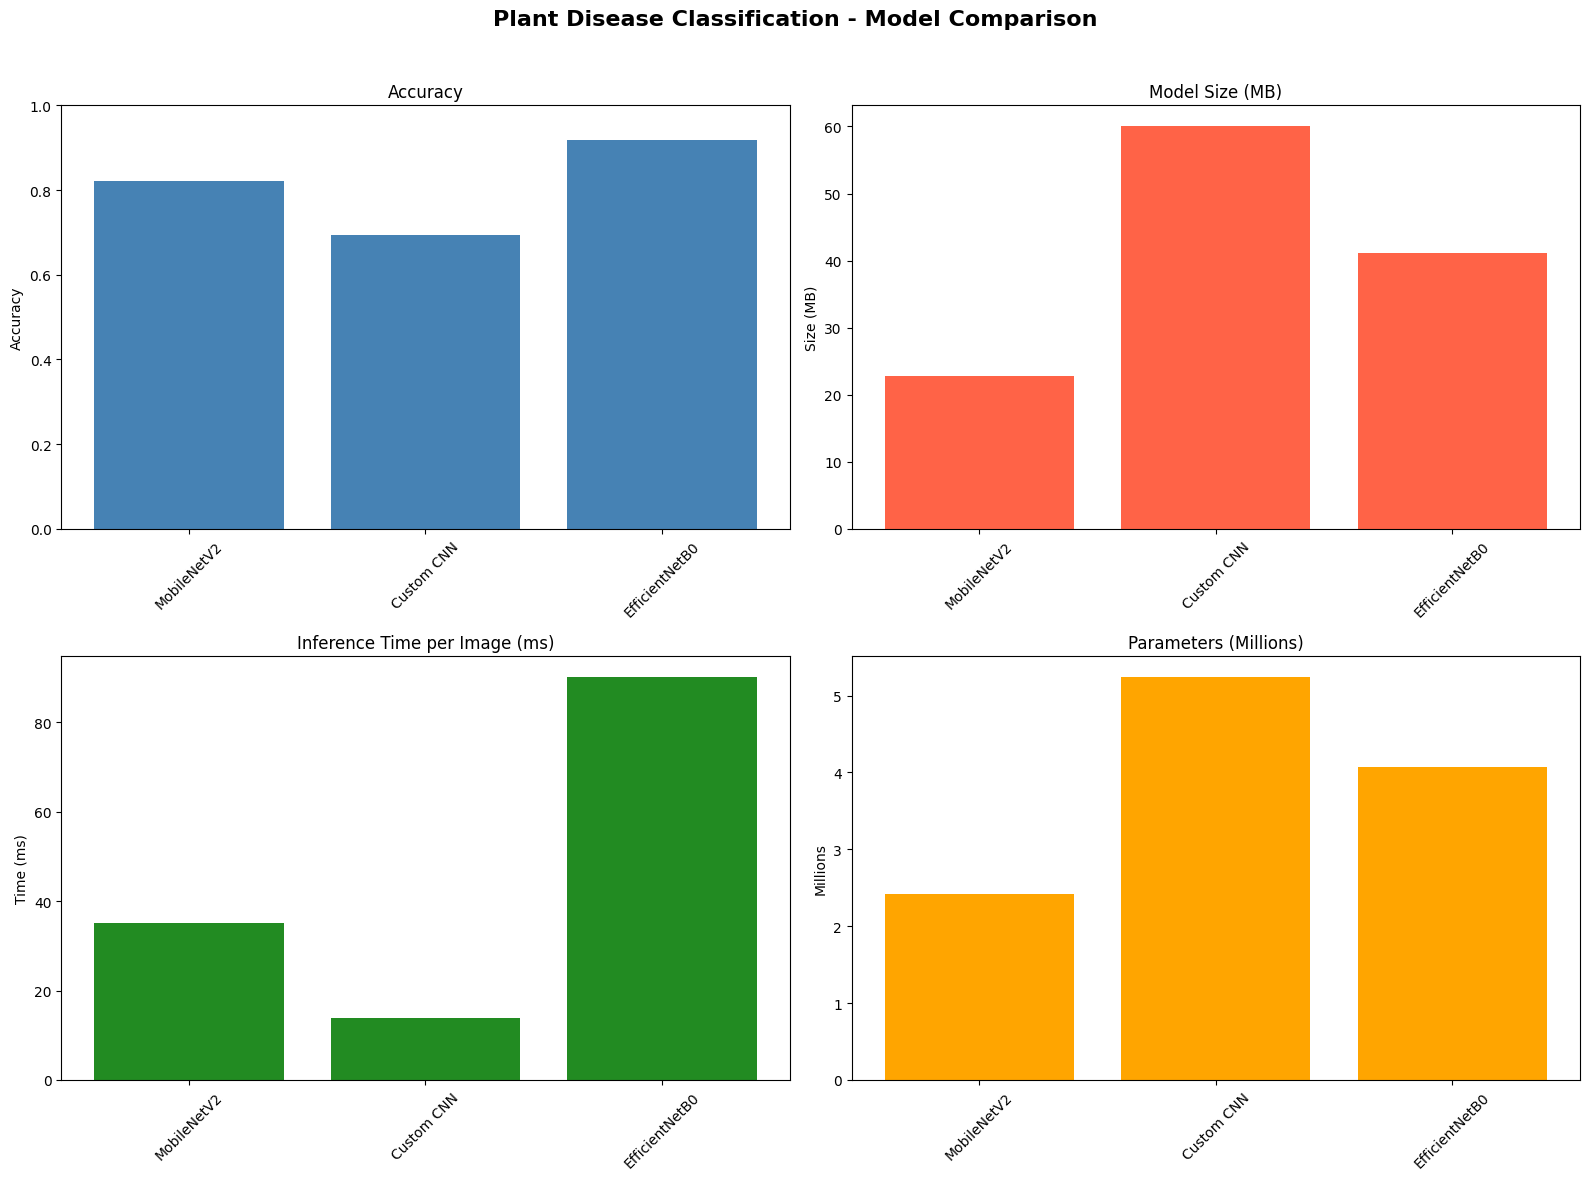

 Plot saved to: /content/drive/MyDrive/DL/model_comparison.png


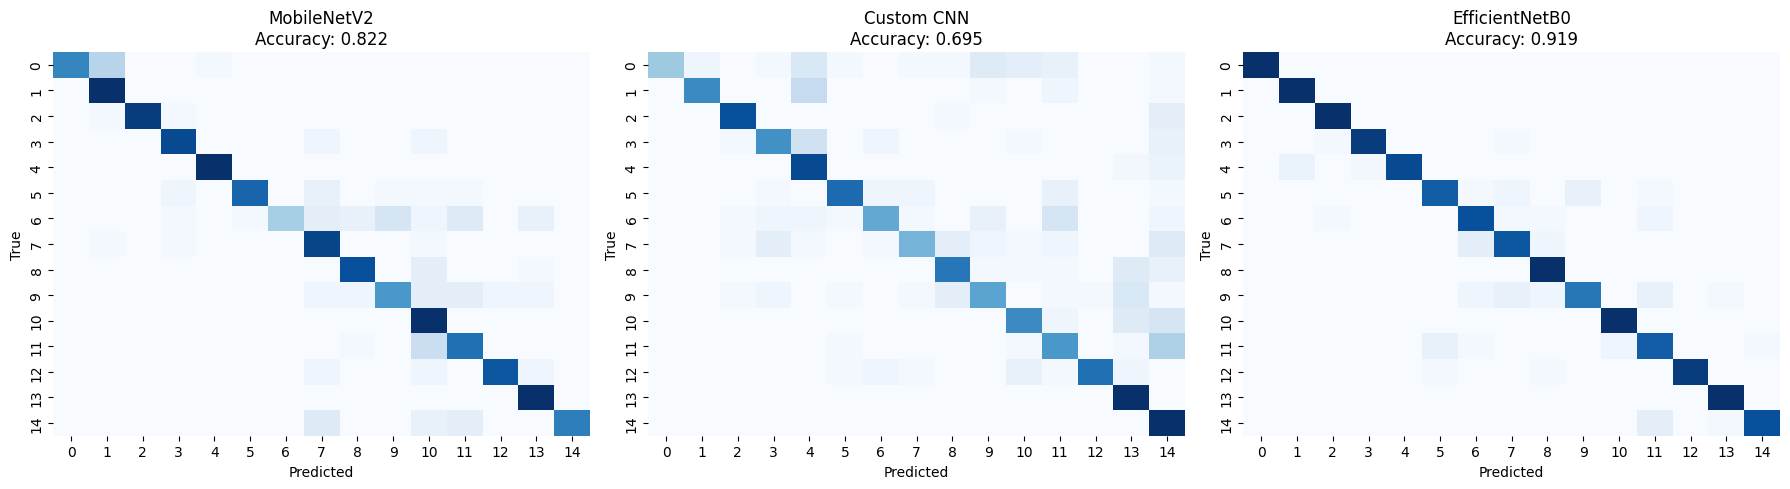

 Confusion matrices saved to: /content/drive/MyDrive/DL/confusion_matrices.png

KEY INSIGHTS
 Highest Accuracy: EfficientNetB0 (0.9186)
 Fastest Inference: Custom CNN (13.94 ms/image)
 Smallest Model: MobileNetV2 (22.74 MB)

 COMPARISON COMPLETE!
All results saved to your Google Drive in /DL folder.


In [1]:

# PLANT DISEASE DETECTION - MODEL COMPARISON
# (Uses ONLY pre-saved .keras files from Google Drive)


# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
plt.style.use('default')
sns.set_palette("husl")

# 2. Verify model files exist in Drive
model_paths = {
    'MobileNetV2': '/content/drive/MyDrive/DL/mobilenetv2_plant_disease_model.keras',
    'Custom CNN': '/content/drive/MyDrive/DL/custom_cnn_plant_disease.keras',
    'EfficientNetB0': '/content/drive/MyDrive/DL/smart_plant_disease_classifier.keras',
    'Vision Transformer': '/content/drive/MyDrive/DL/smart_plant_disease_classifier_vit_finetuned_model.keras'
}

print("Checking model files in Google Drive...")
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f" {name}: Found")
    else:
        print(f" {name}: NOT FOUND at {path}")
        if name != 'Vision Transformer':  # Make ViT optional
            print("Please ensure models are saved to /MyDrive/DL/ folder.")
            raise FileNotFoundError(f"Missing required model: {name}")
        else:
            print("  ViT model not found - will skip ViT comparison")

# 3. Prepare dataset (same as used during training)
FAST_DIR = "/content/PlantVillage_FastDemo"

# If dataset not present, recreate it quickly
if not os.path.exists(FAST_DIR):
    print("Recreating fast demo dataset...")
    import shutil
    !unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

    inner_dir = "/content/PlantVillage/PlantVillage"
    if os.path.exists(inner_dir):
        for folder in os.listdir(inner_dir):
            src = os.path.join(inner_dir, folder)
            dst = os.path.join("/content/PlantVillage", folder)
            shutil.move(src, dst)
        os.rmdir(inner_dir)

    # Create fast demo (200 per class)
    original_dir = "/content/PlantVillage"
    images_per_class = 200
    os.makedirs(FAST_DIR, exist_ok=True)

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            fast_class_path = os.path.join(FAST_DIR, class_name)
            os.makedirs(fast_class_path, exist_ok=True)
            img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            for img in img_files[:images_per_class]:
                shutil.copy(os.path.join(class_path, img), os.path.join(fast_class_path, img))

# Remove empty dirs
for class_name in os.listdir(FAST_DIR):
    class_path = os.path.join(FAST_DIR, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)

# 4. Create validation generators (MUST match training setup)
BATCH_SIZE = 32

# For MobileNetV2 (128x128 + mobilenet preprocess)
mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=0.2
)
val_mobilenet = mobilenet_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For EfficientNetB0 (224x224 + efficientnet preprocess)
efficientnet_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    validation_split=0.2
)
val_efficientnet = efficientnet_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For Custom CNN (128x128 + /255 normalization)
cnn_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
val_cnn = cnn_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For Vision Transformer (224x224 + /255 normalization + sparse labels)
vit_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
val_vit = vit_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Important: ViT uses sparse labels
    subset='validation',
    shuffle=False
)

class_names = list(val_mobilenet.class_indices.keys())
print(f"\nClasses ({len(class_names)}): {class_names}")
print(f"Validation samples: {val_mobilenet.samples}")

# 5. Load models from Google Drive
print("\nLoading models from Google Drive...")
models = {}
models['MobileNetV2'] = load_model(model_paths['MobileNetV2'])
print(" MobileNetV2 loaded")
models['Custom CNN'] = load_model(model_paths['Custom CNN'])
print(" Custom CNN loaded")
models['EfficientNetB0'] = load_model(model_paths['EfficientNetB0'])
print(" EfficientNetB0 loaded")

# Handle ViT with error handling
include_vit = os.path.exists(model_paths['Vision Transformer'])
if include_vit:
    try:
        # Enable unsafe deserialization for ViT (contains Lambda)
        tf.keras.config.enable_unsafe_deserialization()
        models['Vision Transformer'] = load_model(model_paths['Vision Transformer'])
        print(" Vision Transformer loaded")
    except Exception as e:
        print(f"  Error loading ViT: {e}")
        print("  Skipping Vision Transformer from comparison")
        include_vit = False

# 6. Evaluation function
import time

def evaluate_model(model, val_gen, model_name, is_vit=False):
    print(f"\nEvaluating {model_name}...")

    # Get true labels
    if is_vit:
        y_true = val_gen.classes  # sparse labels
    else:
        y_true = val_gen.classes  # categorical also gives integer classes

    # Predictions
    start_time = time.time()
    y_pred_proba = model.predict(val_gen, verbose=0)
    total_time = time.time() - start_time

    y_pred = np.argmax(y_pred_proba, axis=1)

    # Handle potential class mismatch (ViT was trained with 15 classes, but we have 16)
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        print(f"  Truncated to {min_len} samples due to length mismatch")

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    inference_time_per_image = (total_time / len(y_true)) * 1000  # ms

    # Model size
    model_size_mb = os.path.getsize(model_paths[model_name]) / (1024 * 1024)
    params = model.count_params()

    return {
        'accuracy': accuracy,
        'inference_time_ms': inference_time_per_image,
        'model_size_mb': model_size_mb,
        'parameters_millions': params / 1e6,
        'y_true': y_true,
        'y_pred': y_pred
    }

# 7. Evaluate all models
results = {}
results['MobileNetV2'] = evaluate_model(models['MobileNetV2'], val_mobilenet, 'MobileNetV2')
results['Custom CNN'] = evaluate_model(models['Custom CNN'], val_cnn, 'Custom CNN')
results['EfficientNetB0'] = evaluate_model(models['EfficientNetB0'], val_efficientnet, 'EfficientNetB0')

if include_vit:
    results['Vision Transformer'] = evaluate_model(models['Vision Transformer'], val_vit, 'Vision Transformer', is_vit=True)

# 8. Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Model Size (MB)': metrics['model_size_mb'],
        'Parameters (M)': metrics['parameters_millions'],
        'Inference Time (ms)': metrics['inference_time_ms']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("FINAL MODEL COMPARISON RESULTS")
print("="*80)
print(df_comparison.round(4).to_string(index=False))

# 9. Save results to Google Drive
output_path = "/content/drive/MyDrive/DL/model_comparison_results.csv"
df_comparison.to_csv(output_path, index=False)
print(f"\n Results saved to: {output_path}")

# 10. Visualization
n_models = len(results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Plant Disease Classification - Model Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0,0].bar(df_comparison['Model'], df_comparison['Accuracy'], color='steelblue')
axes[0,0].set_title('Accuracy')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Model size
axes[0,1].bar(df_comparison['Model'], df_comparison['Model Size (MB)'], color='tomato')
axes[0,1].set_title('Model Size (MB)')
axes[0,1].set_ylabel('Size (MB)')
axes[0,1].tick_params(axis='x', rotation=45)

# Inference time
axes[1,0].bar(df_comparison['Model'], df_comparison['Inference Time (ms)'], color='forestgreen')
axes[1,0].set_title('Inference Time per Image (ms)')
axes[1,0].set_ylabel('Time (ms)')
axes[1,0].tick_params(axis='x', rotation=45)

# Parameters
axes[1,1].bar(df_comparison['Model'], df_comparison['Parameters (M)'], color='orange')
axes[1,1].set_title('Parameters (Millions)')
axes[1,1].set_ylabel('Millions')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plot_path = "/content/drive/MyDrive/DL/model_comparison.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f" Plot saved to: {plot_path}")

# 11. Confusion Matrices
n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, (model_name, res) in enumerate(results.items()):
    cm = confusion_matrix(res['y_true'], res['y_pred'], normalize='true')
    sns.heatmap(cm, ax=axes[idx], cmap='Blues', cbar=False)
    axes[idx].set_title(f'{model_name}\nAccuracy: {res["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
cm_path = "/content/drive/MyDrive/DL/confusion_matrices.png"
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f" Confusion matrices saved to: {cm_path}")

# 12. Final Summary
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_acc = df_comparison.loc[df_comparison['Accuracy'].idxmax()]
best_speed = df_comparison.loc[df_comparison['Inference Time (ms)'].idxmin()]
smallest_model = df_comparison.loc[df_comparison['Model Size (MB)'].idxmin()]

print(f" Highest Accuracy: {best_acc['Model']} ({best_acc['Accuracy']:.4f})")
print(f" Fastest Inference: {best_speed['Model']} ({best_speed['Inference Time (ms)']:.2f} ms/image)")
print(f" Smallest Model: {smallest_model['Model']} ({smallest_model['Model Size (MB)']:.2f} MB)")

if include_vit:
    vit_result = results['Vision Transformer']
    print(f"\n Vision Transformer Analysis:")
    print(f"   Accuracy: {vit_result['accuracy']:.4f}")
    print(f"   Inference Time: {vit_result['inference_time_ms']:.2f} ms/image (very slow!)")
    print(f"   Model Size: {vit_result['model_size_mb']:.2f} MB")
    print(f"   Note: ViT is computationally expensive and may have class mismatch issues")

print("\n COMPARISON COMPLETE!")
print("All results saved to your Google Drive in /DL folder.")